<a href="https://colab.research.google.com/github/alonsosilvaallende/Random_Forests_Calhousing/blob/master/Random_Forests_for_California_Housing_Dataset-colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Random Forests: a practical guide

[Alonso Silva](http://www.dim.uchile.cl/~alsilva/) [(@alonsosilva)](https://twitter.com/alonsosilva) | 2019/09/04

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## An example: the california housing dataset

We are trying to predict the target variable: the average house value for California districts.

In [0]:
# download the dataset
from sklearn.datasets import fetch_california_housing

calhousing = fetch_california_housing()

In [3]:
# description of the dataset
print(calhousing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [4]:
# feature names
print(calhousing.feature_names)

['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


In [5]:
# create a dataframe with the feature variables
df_raw = pd.DataFrame(calhousing.data, columns=calhousing.feature_names)

# view the top 5 rows
df_raw.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [0]:
# add the target variable to the dataframe
df_raw['Target'] = calhousing.target

In [7]:
df_raw.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


## Data processing

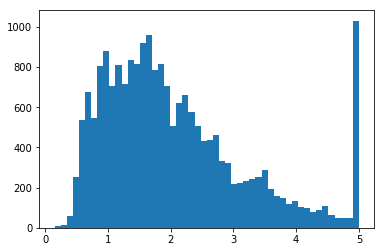

In [8]:
# histogram of the prices of houses (in US$ 100,000)
plt.hist(df_raw['Target'], bins=50);

There seems to be an answer of 'more than US$ 500,000' so we exclude those values who pollute the dataset.

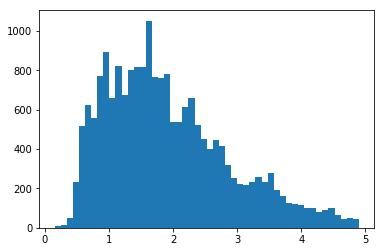

In [9]:
plt.hist(df_raw.query('Target < 4.9')['Target'], bins=50);

In [0]:
df_raw = df_raw.query('Target < 4.9')

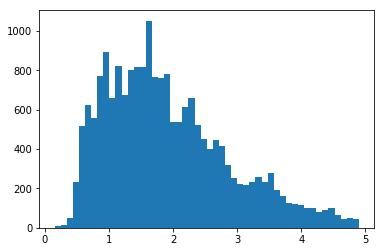

In [11]:
plt.hist(df_raw['Target'], bins=50);

We are interested on the percentage difference between our predictions and the actuals, not the absolute difference.

In [0]:
# percentage so we take the logarithm of the target variable
df_raw['Target'] = np.log(df_raw['Target'])

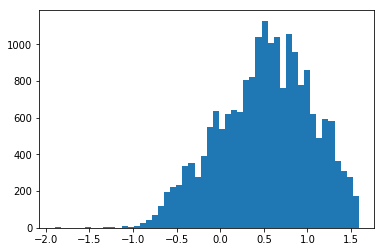

In [13]:
plt.hist(df_raw['Target'], bins=50);

Split the dataset into training and validation datasets.

In [14]:
len(df_raw)

19608

In [0]:
n_trn = len(df_raw)-1000

In [0]:
def split_vals(a,n): return a[:n], a[n:]

In [0]:
df_raw = df_raw.sample(frac=1, random_state=42).reset_index(drop=True) # Shuffle the rows
X_trn, X_val = split_vals(df_raw.drop(['Target'], axis='columns'), n_trn)
y_trn, y_val = split_vals(df_raw['Target'], n_trn)

In [0]:
y_val.reset_index(drop=True);

In [19]:
# Check if the train/valid sets and the train/valid targets have the same number of observations
len(X_trn)==len(y_trn), len(X_val)==len(y_val) 

(True, True)

In [20]:
# number of observations in the training set and the validation set
len(y_trn), len(y_val)

(18608, 1000)

Scaling the features.

In [0]:
X_trn_s = (X_trn - X_trn.mean())/X_trn.std()
X_val_s = (X_val - X_trn.mean())/X_trn.std()

## Data analysis

In [0]:
# cost function (percent mean squared error but we already took the log so it's just mean squared error)
import math

def rmse(x,y): return math.sqrt(((x-y)**2).mean())

Function to plot predictions vs actuals

In [0]:
def scatter_predictions(y_pred, y_true):
    plt.figure(figsize=(6, 6))
    plt.xlabel('prediction')
    plt.ylabel('true target')
    plt.xlim(-1, 6)
    plt.ylim(-1, 6)
    plt.scatter(np.exp(y_pred), np.exp(y_true))
    plt.plot(np.linspace(-1,6), np.linspace(-1,6))
    plt.show()

For linear regression, we need to use the scaled columns.

In [24]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression()
lm.fit(X_trn_s, y_trn)
print(f'train error: {rmse(lm.predict(X_trn_s), y_trn):.3f}, valid error: {rmse(lm.predict(X_val_s), y_val):.3f}')
print(f'train score: {lm.score(X_trn_s, y_trn):.3f}, valid score: {lm.score(X_val_s, y_val):.3f}')

train error: 0.334, valid error: 0.328
train score: 0.604, valid score: 0.601


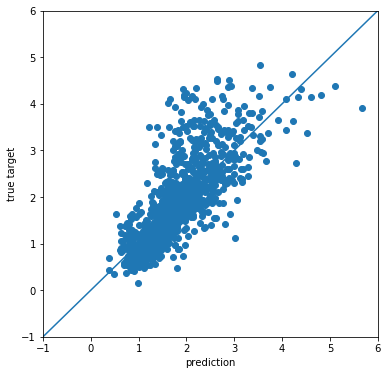

In [25]:
scatter_predictions(lm.predict(X_val_s), y_val)

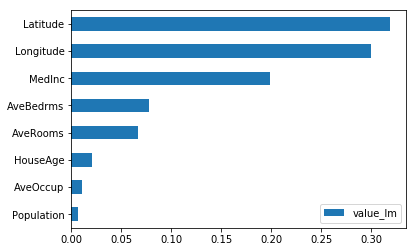

In [26]:
# Feature importance
featcoef_lm = lm.coef_
rel_featcoef_lm = np.abs(featcoef_lm)/np.sum(np.abs(featcoef_lm))
lab = df_raw.drop(['Target'], axis=1).columns
df_featcoef_lm = pd.DataFrame({'lab_lm': lab, 'value_lm': rel_featcoef_lm}, index=lab)
df_featcoef_lm = df_featcoef_lm.sort_values(by='value_lm', ascending=True)
df_featcoef_lm.plot.barh(y='value_lm');

## Random forests

In [27]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

rfm = RandomForestRegressor(n_estimators=50, min_samples_leaf=1, max_features=.5, n_jobs=-1, random_state=42)
rfm.fit(X_trn, y_trn)
print(f'train error: {rmse(rfm.predict(X_trn), y_trn):.3f}, valid error: {rmse(rfm.predict(X_val), y_val):.3f}')
print(f'train score: {rfm.score(X_trn, y_trn):.3f}, valid score: {rfm.score(X_val, y_val):.3f}')

train error: 0.084, valid error: 0.217
train score: 0.975, valid score: 0.825


Holy cow! Our error diminished by $34\%$ and our score improved by $37\%$.

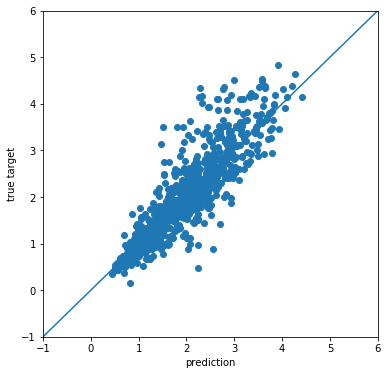

In [28]:
scatter_predictions(rfm.predict(X_val), y_val)

Our predictions are much less disperse compared to the predictions of the linear model.

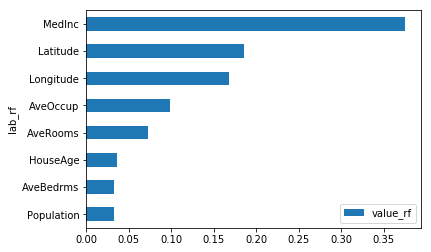

In [29]:
featcoef_rfm = rfm.feature_importances_
rel_featcoef_rfm = np.abs(featcoef_rfm)/np.sum(np.abs(featcoef_rfm))
df_featcoef_rfm = pd.DataFrame({'lab_rf': lab, 'value_rf': rel_featcoef_rfm})
df_featcoef_rfm = df_featcoef_rfm.sort_values(by='value_rf', ascending=True)
df_featcoef_rfm.plot.barh(x='lab_rf', y='value_rf');

The most important feature of the price of a house is the average income in the bloc. Location features (Longitude and Latitude) seem to be very important as well (but less important compared to the feature importance given to them by the linear model).

## Bonus track: Prediction intervals of random forests

Random forests give us the estimation given by several decision trees, so we get for free the standard deviation of these predictions.

In [30]:
preds = np.stack([t.predict(X_val) for t in rfm.estimators_])
print(f'Predicted value first house: {np.mean(preds[:,0]):.2f}, Standard deviation of the prediction: {np.std(preds[:,0]):.2f}')

Predicted value first house: 0.37, Standard deviation of the prediction: 0.28


We compute the predictions and their standard deviations.

In [0]:
pred = [np.mean(preds[:,i]) for i in range(len(X_val))]
pred_std = [np.std(preds[:,i]) for i in range(len(X_val))]

How many predictions are within 1 standard deviation? 2 standard deviations? 3 standard deviations?

In [32]:
pred_int1 = sum([pred[i]-1*pred_std[i] <= y_val.iloc[i] <= pred[i]+1*pred_std[i] for i in range(len(pred))])
print(f'Within 1 standard deviation: {100*pred_int1/len(pred):.1f}%%')

Within 1 standard deviation: 79.9%%


In [33]:
pred_int2 = sum([pred[i]-2*pred_std[i] <= y_val.iloc[i] <= pred[i]+2*pred_std[i] for i in range(len(pred))])
print(f'Within 2 standard deviation: {100*pred_int2/len(pred):.1f}%%')

Within 2 standard deviation: 98.2%%


In [34]:
pred_int3 = sum([pred[i]-3*pred_std[i] <= y_val.iloc[i] <= pred[i]+3*pred_std[i] for i in range(len(pred))])
print(f'Within 3 standard deviation: {100*pred_int3/len(pred):.1f}%%')

Within 3 standard deviation: 99.2%%


Compared to the [68-95-99.7 rule](https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule) of the normal distribution, I think it's quite a remarkable empirical prediction. 

Sources:
+ [Gradient Boosting: a practical guide](https://nbviewer.jupyter.org/github/ogrisel/notebooks/blob/master/sklearn_demos/Gradient%20Boosting.ipynb)
+ [FastAI Machine Learning for Coders](https://course18.fast.ai/ml)